In [147]:
import pandas as pd
import numpy as np
import random
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE
from keras.layers import Normalization, Input, Dense, Dropout
from keras.models import Sequential
from keras.initializers import glorot_uniform
from keras.regularizers import l2

In [2]:
url1 = "https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-/blob/main/Data/Data_10_genex.xlsx?raw=true"
url2 = "https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-/blob/main/Data/Table%2010.xlsx?raw=true"

gene_expression = pd.read_excel(url1).T.sort_index().iloc[:-2,:]
patient_data = pd.read_excel(url2,index_col="Sample_ID").sort_index()


In [199]:
def tSNE(gene_expression, patient_data, var_of_interest, n):

    tsne = TSNE(n, perplexity = 20, verbose=1, random_state = 69)
    tsne_res = tsne.fit_transform(gene_expression)

    return tsne_res

In [184]:
def embedding_TSNE(tsne_coordinates,handles, patient_data, var_of_interest, p, weighted = True):

    patient_categories = patient_data[var_of_interest]
    categories = np.unique(patient_categories)
    clusters = {entity:tsne_coordinates[patient_categories == entity] for entity in categories}

    dimension = len(clusters[list(clusters.keys())[0]][0,:])
    embedding = []
 
    num_colors = len(np.unique(patient_categories))
    colors = plt.get_cmap('rainbow', num_colors)
    
    fig = plt.figure(figsize=(14,10))

    for entity in enumerate(clusters):

        i = entity[0]
        entity = entity[1]

        coords = clusters[entity]
        n_entities = len(coords)
        d = distance_matrix(coords,coords)**p
        

        if weighted == True:
            weights = 1/np.array([np.sum(d[i]) for i in range(n_entities)])
        else:
            weights = np.ones(n_entities)

        com = [sum(coords[:,i]*weights)/sum(weights) for i in range(dimension)]
        embedding.append(com)
        clusters[entity] = clusters[entity], weights, com

        if dimension == 2:
            plt.scatter(coords[:,0],coords[:,1],label=entity,color=colors(i))
            plt.scatter(com[0], com[1], s = 180, color = 'black', marker = 'x')
    
    coordinates = ["X","Y","Z"]
    names = []
    for d in range(dimension):
        names.append(coordinates[d])
    # if dimension == 3:
    #     names = ["X","Y","Z"]
    # else:
    #     names = ["X","Y"]
    embedding = pd.DataFrame(embedding, index=categories, columns = names)
    plt.legend()
    plt.xlabel('tSNE-one')
    plt.ylabel('tSNE-two')

    return clusters, embedding

In [5]:
def data_preprocessing(gene_expression, patient_data, var_of_interest, split = 0.75):

    x = gene_expression.astype("float32")
    y = patient_data[var_of_interest]
    labels = np.sort(np.unique(y))
    print(labels)

    num_patients = x.shape[0]
    ind_shuffle = random.sample(list(range(num_patients)), num_patients)
    train_size = int(split*num_patients) 

    x_train = x.iloc[ind_shuffle][:train_size]
    y_train = y.iloc[ind_shuffle][:train_size]

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(x_train)

    x_test = x.iloc[ind_shuffle][train_size:]
    y_test = y.iloc[ind_shuffle][train_size:]

    #y_train = pd.get_dummies(y_train)
    #y_test = pd.get_dummies(y_test)

    y_train = tf.keras.utils.to_categorical(np.array([np.where(labels==id)[0][0] for i, id in enumerate(y_train)]))
    y_test = tf.keras.utils.to_categorical(np.array([np.where(labels==id)[0][0] for i, id in enumerate(y_test)]))

    if y_train.shape[1] != y_test.shape[1]:
        print("lol run again haha")

    return x_train, y_train, x_test, y_test, normalizer

In [6]:
def build_model(hid_layers, dropout, activation, L2, in_out_size, normalizer):

    model = Sequential()
    model.add(Input(shape=(in_out_size[0],)))
    model.add(normalizer)

    for i in range(len(hid_layers)-1):
        model.add(Dense(hid_layers[i],
                        activation = activation[i],
                        kernel_initializer=glorot_uniform(),
                        kernel_regularizer=l2(L2[i])
                        )
        )
        model.add(Dropout(dropout[i]))

    model.add(Dense(in_out_size[1],
              activation = activation[-1],
              kernel_initializer=glorot_uniform(),
              kernel_regularizer=l2(L2[-1])
              )
    )

    return model

In [7]:
def plot(history,size):

    fig = plt.figure(figsize=(size*2,size))

    plt.subplot(1,2,1)
    x_axis = np.arange(1, len(history.history['loss'])+1)
    plt.plot(x_axis, history.history['loss'], label='training')
    plt.plot(x_axis, history.history['val_loss'], label='validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1,2,2)
    x_axis = np.arange(1, len(history.history['accuracy'])+1)
    plt.plot(x_axis, history.history['accuracy'], label='training')
    plt.plot(x_axis, history.history['val_accuracy'], label='validation')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    return 'plot'

['11q23 rearranged' 'AMKL-I' 'AMKL-II' 'AMKL-III' 'AMTL' 'MK-I' 'MK-II'
 'MK-III' 'MK-IV' 'MK-V' 'MPAL-B/M' 'inv(16)' 't(8;21)']
4/4 [==============================] - 0s 4ms/step - loss: 0.1597 - accuracy: 0.9358


[0.15966178476810455, 0.9357798099517822]

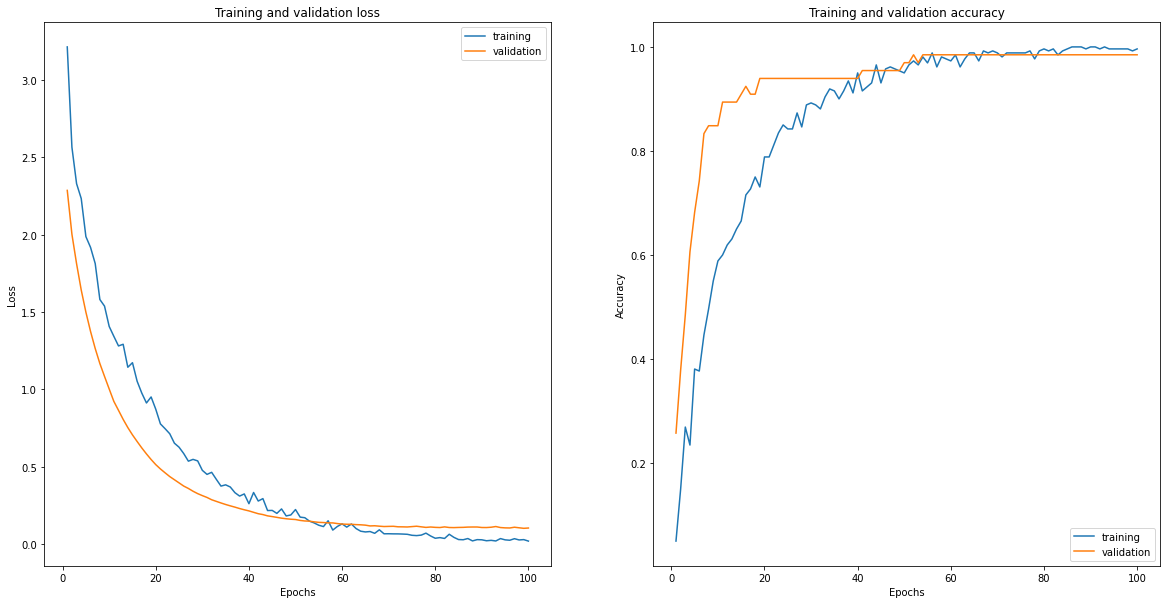

In [8]:
x_train, y_train, x_test, y_test, normalizer = data_preprocessing(gene_expression,
                                                                  patient_data,
                                                                  "Transcriptional_Identity")
hid_layers  = [512,256,128]
dropout     = [0.5,0.4,0.3]
activation  = ["relu","relu","relu","softmax"]
L2          = [0,0,0]
in_out_size = [x_train.shape[1],y_train.shape[1]]

model = build_model(hid_layers,
                    dropout,
                    activation,
                    L2,
                    in_out_size, 
                    normalizer)

model.compile(loss = "categorical_crossentropy", 
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              metrics=["accuracy"])

history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    verbose=False,
                    batch_size=64, 
                    validation_split=0.2)

plot(history,10)
model.evaluate(x_test, y_test)